In [1]:
%pylab inline
import astropy.io.fits as fits
import numpy as np
from astroquery.jplhorizons import Horizons
import os
from astropy.table import Table
import time

Populating the interactive namespace from numpy and matplotlib


In [2]:
# this is being run on my laptop, haven't tried installing astroquery on e.g., NERSC or Harvard Odyssey yet
print(os.environ['HOME'])

/Users/ameisner


In [3]:
# read in the DECaLS DR2 asteroids file

hdul = fits.open('asteroids_decals_dr2.fits')
t = Table(hdul[1].data)

print('There were ' + str(len(t)) + ' known solar system object sightings found in DECaLS DR2.')
print('There were ' + str(len(np.unique(t['NAME']))) + ' unique known solar system objects seen in DECaLS DR2 data.')

There were 1168505 known solar system object sightings found in DECaLS DR2.
There were 200124 unique known solar system objects seen in DECaLS DR2 data.


In [4]:
# this is what the data in my DR2 known SSO table look like
t[0:9]

<Table length=9>
       NAME       EXPNUM        JD        ...        MAG         EXPTIME
      str17       int32      float64      ...      float64       float64
----------------- ------ ---------------- ... ------------------ -------
1999 DC2          173294 2456322.52899331 ... 19.700000762939453   120.0
2000 AM167        173294 2456322.52899331 ...  20.18000030517578   120.0
2004 TY364        173294 2456322.52899331 ... 20.649999618530273   120.0
2000 AY152        173294 2456322.52899331 ... 20.100000381469727   120.0
2001 QT102        173294 2456322.52899331 ... 21.209999084472656   120.0
2004 BK103        173294 2456322.52899331 ... 21.649999618530273   120.0
2006 PQ36         173294 2456322.52899331 ...  20.93000030517578   120.0
2000 CC73         173294 2456322.52899331 ...  21.90999984741211   120.0
2005 RS29         173294 2456322.52899331 ... 21.559999465942383   120.0

In [5]:
# start by seeing how the (ra, dec) coordinates at the start of the exposure in the 
# first row of asteroids_decals_dr2.fits compare to what astroquery returns

ctio = 807 # CTIO observatory code

obj = Horizons(id=t[0]['NAME'], location=ctio, epochs=t[0]['JD'])
eph = obj.ephemerides()
eph

<Table masked=True length=1>
   targetname          datetime_str         datetime_jd    ...  PABLon  PABLat 
      ---                  ---                   d         ...   deg     deg   
     str16                str24               float64      ... float64 float64 
---------------- ------------------------ ---------------- ... ------- --------
33424 (1999 DC2) 2013-Jan-30 00:41:45.022 2456322.52899331 ... 44.8307 -23.5968

In [6]:
dra_asec = (eph[0]['RA'] - t[0]['RA0'])*3600.0*np.cos(t[0]['DEC0']*np.pi/180.0)
ddec_asec = (eph[0]['DEC'] - t[0]['DEC0'])*3600.0
print('difference in RA for first row : ' + '{:.4f}'.format(dra_asec) + ' asec')
print('difference in Dec for first row : ' + '{:.4f}'.format(ddec_asec) + ' asec')

difference in RA for first row : -0.0641 asec
difference in Dec for first row : 0.0358 asec


In [7]:
# restrict to rows with high-fidelity ephemerides
t = t[(np.isfinite(t['DRA0'])) & (np.isfinite(t['DDEC0'])) & (t['DRA0'] < 0.5) & (t['DDEC0'] < 0.5)]
print(str(len(t)) + ' rows retained')

868390 rows retained


/Users/ameisner/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


In [8]:
# now try a random sample of 250 SSO sightings drawn from the full asteroids_decals_dr2.fits table

seed = 50
np.random.seed(seed=seed)

nrow = 250
ind = np.random.choice(len(t), nrow)
_t = t[ind]

In [9]:
def radec_differences_astroquery_vs_telnet(row):
    # row is one row of asteroids_decals_dr2.fits table
    obj = Horizons(id=row['NAME'], location=ctio, epochs=row['JD'])
    eph = obj.ephemerides()
    dra_asec = (eph[0]['RA'] - row['RA0'])*3600.0*np.cos(row['DEC0']*np.pi/180.0)
    ddec_asec = (eph[0]['DEC'] - row['DEC0'])*3600.0
    return dra_asec, ddec_asec

In [10]:
dra_list = np.zeros(nrow)
ddec_list = np.zeros(nrow)
dt_list = np.zeros(nrow) # seconds
for i, __t in enumerate(_t):
    if (i % 10) == 0: print(i)
    t0 = time.time()
    dra, ddec = radec_differences_astroquery_vs_telnet(__t)
    dt_list[i] = time.time()-t0 # seconds
    dra_list[i] = dra
    ddec_list[i] = ddec

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240


Text(0,0.5,'number/bin')

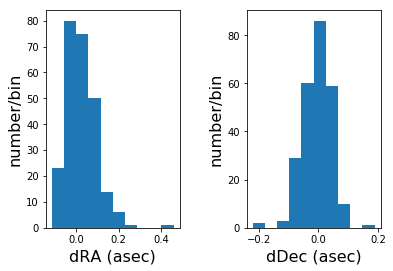

In [11]:
# make histograms of dra, ddec, dt
subplot(1,2,1)
subplots_adjust(wspace=0.5)
hist(dra_list)
xlabel('dRA (asec)', fontsize=16)
ylabel('number/bin', fontsize=16)
subplot(1,2,2)
hist(ddec_list)
xlabel('dDec (asec)', fontsize=16)
ylabel('number/bin', fontsize=16)

Text(0,0.5,'queries/bin')

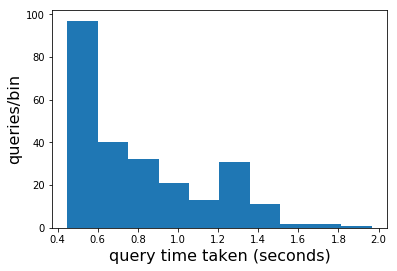

In [12]:
hist(dt_list)
xlabel('query time taken (seconds)', fontsize=16)
ylabel('queries/bin', fontsize=16)

Text(0,0.5,'dRA (asec)')

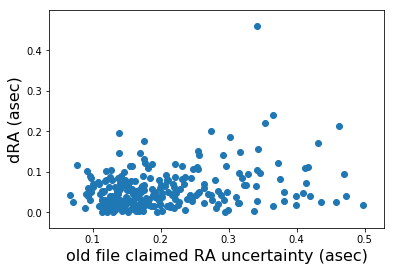

In [13]:
# kind of would have hoped for more of a correlation here...
scatter(_t['DRA0'], np.abs(dra_list))
xlabel('old file claimed RA uncertainty (asec)', fontsize=16)
ylabel('dRA (asec)', fontsize=16)

Text(0,0.5,'dDec (asec)')

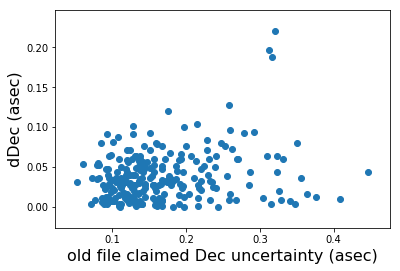

In [14]:
# kind of would have hoped for more of a correlation here...
scatter(_t['DDEC0'], np.abs(ddec_list))
xlabel('old file claimed Dec uncertainty (asec)', fontsize=16)
ylabel('dDec (asec)', fontsize=16)